In [ ]:
# !unzip sequence_img_data.zip

In [5]:

BATCH_SIZE=16

IMAGE_SIZE_WIDTH= 80
IMAGE_SIZE_HEIGHT = 60 
NUM_CHANNEL = 3                                   

IMAGE_SHAPE = (IMAGE_SIZE_HEIGHT, IMAGE_SIZE_WIDTH) #(height, width)
MODEL_IMAGE_SHAPE = (IMAGE_SIZE_HEIGHT, IMAGE_SIZE_WIDTH, NUM_CHANNEL) 

In [6]:
train_data_dir='/home/glarus/HOOK_PROJECT/DATA_COLLECTION_HOOK/single_img_data_training/train'
val_data_dir='/home/glarus/HOOK_PROJECT/DATA_COLLECTION_HOOK/single_img_data_training/val'

In [1]:
import tensorflow as tf
import tflite_runtime

print("Tensorflow Version : ", tf.__version__)
print("Tensorflow Lite Version : ", tflite_runtime.__version__)

2023-07-05 11:18:01.149730: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-05 11:18:03.042614: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-07-05 11:18:03.042669: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-07-05 11:18:07.937955: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

Tensorflow Version :  2.11.0
Tensorflow Lite Version :  2.11.0


In [4]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D,Dense,Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model, Sequential

import numpy as np
# !pip install numpy==1.20
import matplotlib.pyplot as plt
# !pip install autokeras
# import autokeras as ak
import glob
import os, cv2, time

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications import MobileNetV3Large

from skimage.util import random_noise

# Generate val data from training samples

In [9]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator





# from tensorflow.keras.layers.preprocessing.image_preprocessing import HORIZONTAL

train_datagen=ImageDataGenerator(   rotation_range=15,       # Rotate images randomly up to 20 degrees
                                    width_shift_range=0.15,   # Shift the width by a fraction of the total width
                                    height_shift_range=0.15,  # Shift the height by a fraction of the total height
                                    zoom_range=0.15,# Randomly zoom into images by up to 20%
                                    shear_range=0.15, 
#                                     zca_whitening= True,
                                    brightness_range=[0.8, 1.35], 
                                 )

val_datagen=ImageDataGenerator(#rescale=1./255
                               )




train_generator=train_datagen.flow_from_directory(train_data_dir,
                                                  target_size=IMAGE_SHAPE, # accept height and wdith order
                                                  batch_size=BATCH_SIZE,
#                                                   color_mode="grayscale",
                                                  class_mode='sparse',
                                                  
                                                 )

val_generator=val_datagen.flow_from_directory(val_data_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
#                                               color_mode="grayscale",
                                              class_mode='sparse')






Found 3170 images belonging to 3 classes.
Found 180 images belonging to 3 classes.


In [384]:
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# Get all class name according to the model will be trained and class weights if unbalanced

In [10]:
class_names = list(train_generator.class_indices.keys())
NUM_CLASSES = len(class_names)
print("Class Names : ", class_names)

Class Names :  ['angle', 'none', 'pipe']


In [11]:
class_names_instances = {}
max_instances = 0
for i, folder_path in enumerate(sorted(glob.glob(train_data_dir+"/*"))):

    class_names_instances[folder_path.split("/")[-1]] = len(os.listdir(folder_path))
    if max_instances < len(os.listdir(folder_path)):
        max_instances = len(os.listdir(folder_path))
    

In [12]:
class_names_instances

{'angle': 951, 'none': 1081, 'pipe': 1138}

In [13]:
class_weights = {}


for i, class_name in enumerate(class_names):
    class_weights[i] = max_instances/class_names_instances[class_name]



for i, class_name in enumerate(class_names):
    print(f"{i} : {class_name}")
    
print(" ")

print("class_weights : ",class_weights)

0 : angle
1 : none
2 : pipe
 
class_weights :  {0: 1.1966351209253419, 1: 1.0527289546716003, 2: 1.0}


# Visualize images generated from datagen

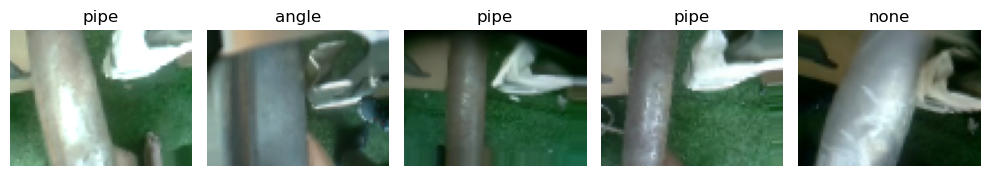

In [14]:
images, labels = next(train_generator)
batch_size =5
fig, axes = plt.subplots(nrows=1, ncols=batch_size, figsize=(10, 4))

for i in range(batch_size):
    
    # Rescale pixel values to [0, 1]
    image = images[i] / 255.0
    
    axes[i].imshow(image)
    axes[i].axis('off')
    axes[i].set_title('{}'.format(class_names[int(labels[i])]))

plt.tight_layout()
plt.show()


# mobile net v3 small

In [25]:


num_classes = 3

base_model = MobileNetV3Small(
                                input_shape=MODEL_IMAGE_SHAPE,
                                alpha=0.01,
                                dropout_rate=0.1,
                                minimalistic=True, # if True, aims to provide a lightweight and efficient model for image classification tasks with minimal computational resources.
                                 
                                include_top=False,
                                weights=None , #'imagenet' , None
                                
                             )
base_model.trainable = True

print(base_model.summary())

Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 60, 80, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 60, 80, 3)    0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 30, 40, 16)   432         ['rescaling[0][0]']              
                                                                                                  
 Conv/BatchNorm (BatchNormaliza  (None, 30, 40, 16)  64          ['Conv[0][0]']                   
 tion)                                                                             

                                                                 rm[0][0]',                       
                                                                  'expanded_conv_2/project/BatchNo
                                                                 rm[0][0]']                       
                                                                                                  
 expanded_conv_3/expand (Conv2D  (None, 8, 10, 32)   256         ['expanded_conv_2/Add[0][0]']    
 )                                                                                                
                                                                                                  
 expanded_conv_3/expand/BatchNo  (None, 8, 10, 32)   128         ['expanded_conv_3/expand[0][0]'] 
 rm (BatchNormalization)                                                                          
                                                                                                  
 re_lu_6 (

                                                                                                  
 expanded_conv_5/Add (Add)      (None, 4, 5, 8)      0           ['expanded_conv_4/Add[0][0]',    
                                                                  'expanded_conv_5/project/BatchNo
                                                                 rm[0][0]']                       
                                                                                                  
 expanded_conv_6/expand (Conv2D  (None, 4, 5, 24)    192         ['expanded_conv_5/Add[0][0]']    
 )                                                                                                
                                                                                                  
 expanded_conv_6/expand/BatchNo  (None, 4, 5, 24)    96          ['expanded_conv_6/expand[0][0]'] 
 rm (BatchNormalization)                                                                          
          

 D)                                                                                               
                                                                                                  
 expanded_conv_8/project/BatchN  (None, 2, 3, 8)     32          ['expanded_conv_8/project[0][0]']
 orm (BatchNormalization)                                                                         
                                                                                                  
 expanded_conv_9/expand (Conv2D  (None, 2, 3, 48)    384         ['expanded_conv_8/project/BatchNo
 )                                                               rm[0][0]']                       
                                                                                                  
 expanded_conv_9/expand/BatchNo  (None, 2, 3, 48)    192         ['expanded_conv_9/expand[0][0]'] 
 rm (BatchNormalization)                                                                          
          

In [40]:
from tensorflow.keras import Model

# Get the number of layers in the base model
num_layers = len(base_model.layers)

# Create a new model without the last 10 layers
new_base_model = Model(base_model.input, base_model.layers[num_layers-75-1].output)

new_base_model.trainable = True

# Print summary
print(new_base_model.summary())

model = tf.keras.Sequential([
    new_base_model,
    Conv2D(3, (3, 3), strides=(1, 1), padding='valid', activation='relu', use_bias=True),
#     layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
#     layers.Dense(16, activation='relu'),
#     layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])


model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 60, 80, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 60, 80, 3)    0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 30, 40, 16)   432         ['rescaling[0][0]']              
                                                                                                  
 Conv/BatchNorm (BatchNormaliza  (None, 30, 40, 16)  64          ['Conv[0][0]']                   
 tion)                                                                                      

                                                                 rm[0][0]',                       
                                                                  'expanded_conv_2/project/BatchNo
                                                                 rm[0][0]']                       
                                                                                                  
Total params: 3,304
Trainable params: 2,904
Non-trainable params: 400
__________________________________________________________________________________________________
None
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 8, 10, 8)          3304      
                                                                 
 conv2d_7 (Conv2D)           (None, 6, 8, 3)           219       
                                                                 
 flatten_5 (

# Train the model

In [41]:
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import datetime
from keras.models import load_model


folder = "TRAINED_MODEL"

current_datetime = datetime.datetime.now()

date_time  = current_datetime.strftime("%Y%m%d_%H%M%S_%f")


final_folder = os.path.join(os.getcwd(), folder, date_time)

try:
    os.mkdir(folder)
except:
    pass

try:
    os.mkdir(final_folder)
except:
    pass


current_datetime = datetime.datetime.now()

model_name  = current_datetime.strftime("%Y%m%d_%H%M%S_%f") +'.h5'

best_model_path = os.path.join(final_folder, model_name)

print("Best model  will be saved in here : ", best_model_path)


checkpoint = ModelCheckpoint(best_model_path,
                             monitor='val_sparse_categorical_accuracy',
                             mode='max',
                             save_best_only=True,verbose=1)

earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=0,
                          patience=5,
                          verbose=1,
                          restore_best_weights=True)

# callbacks=[checkpoint,earlystop]
callbacks=[checkpoint]
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                   optimizer=Adam(learning_rate=0.001),
                   metrics=['sparse_categorical_accuracy'])

epochs=200

#batch_size = 16

history = model.fit(     train_generator,
                        #  steps_per_epoch=num_train_samples//batch_size,
                         epochs=epochs,
                        #validation_split=0.15,
                        callbacks=callbacks,
                         validation_data=val_generator,
                        #  validation_steps=num_val_samples//batch_size
                        class_weight=class_weights,
                    )




# Load the .h5 model
model = load_model(best_model_path)
print("Best model is saved here : ", best_model_path)



Epoch 1/200
199/199 [==============================] - ETA: 0s - loss: 1.0076 - sparse_categorical_accuracy: 0.6416
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.62222, saving model to image_classification_checkpoint.h5
199/199 [==============================] - 7s 26ms/step - loss: 1.0076 - sparse_categorical_accuracy: 0.6416 - val_loss: 0.8825 - val_sparse_categorical_accuracy: 0.6222
Epoch 2/200
199/199 [==============================] - ETA: 0s - loss: 0.4828 - sparse_categorical_accuracy: 0.8309
Epoch 2: val_sparse_categorical_accuracy improved from 0.62222 to 0.69444, saving model to image_classification_checkpoint.h5
199/199 [==============================] - 5s 26ms/step - loss: 0.4828 - sparse_categorical_accuracy: 0.8309 - val_loss: 0.6070 - val_sparse_categorical_accuracy: 0.6944
Epoch 3/200
198/199 [============================>.] - ETA: 0s - loss: 0.4358 - sparse_categorical_accuracy: 0.8437
Epoch 3: val_sparse_categorical_accuracy improved from 0.69444 

Epoch 23/200
199/199 [==============================] - ETA: 0s - loss: 0.2724 - sparse_categorical_accuracy: 0.9050
Epoch 23: val_sparse_categorical_accuracy did not improve from 0.91667
199/199 [==============================] - 5s 25ms/step - loss: 0.2724 - sparse_categorical_accuracy: 0.9050 - val_loss: 0.4178 - val_sparse_categorical_accuracy: 0.8611
Epoch 24/200
198/199 [============================>.] - ETA: 0s - loss: 0.2442 - sparse_categorical_accuracy: 0.9166
Epoch 24: val_sparse_categorical_accuracy did not improve from 0.91667
199/199 [==============================] - 5s 25ms/step - loss: 0.2444 - sparse_categorical_accuracy: 0.9167 - val_loss: 0.4960 - val_sparse_categorical_accuracy: 0.8278
Epoch 25/200
198/199 [============================>.] - ETA: 0s - loss: 0.2460 - sparse_categorical_accuracy: 0.9138
Epoch 25: val_sparse_categorical_accuracy did not improve from 0.91667
199/199 [==============================] - 5s 26ms/step - loss: 0.2451 - sparse_categorical_accu

Epoch 68/200
198/199 [============================>.] - ETA: 0s - loss: 0.1839 - sparse_categorical_accuracy: 0.9372
Epoch 68: val_sparse_categorical_accuracy improved from 0.93889 to 0.94444, saving model to image_classification_checkpoint.h5
199/199 [==============================] - 5s 26ms/step - loss: 0.1833 - sparse_categorical_accuracy: 0.9375 - val_loss: 0.2225 - val_sparse_categorical_accuracy: 0.9444
Epoch 69/200
198/199 [============================>.] - ETA: 0s - loss: 0.1983 - sparse_categorical_accuracy: 0.9350
Epoch 69: val_sparse_categorical_accuracy improved from 0.94444 to 0.95556, saving model to image_classification_checkpoint.h5
199/199 [==============================] - 5s 26ms/step - loss: 0.1976 - sparse_categorical_accuracy: 0.9353 - val_loss: 0.1968 - val_sparse_categorical_accuracy: 0.9556
Epoch 70/200
198/199 [============================>.] - ETA: 0s - loss: 0.1995 - sparse_categorical_accuracy: 0.9334
Epoch 70: val_sparse_categorical_accuracy did not impro

Epoch 91/200
199/199 [==============================] - ETA: 0s - loss: 0.1650 - sparse_categorical_accuracy: 0.9473
Epoch 91: val_sparse_categorical_accuracy did not improve from 0.95556
199/199 [==============================] - 5s 25ms/step - loss: 0.1650 - sparse_categorical_accuracy: 0.9473 - val_loss: 0.2609 - val_sparse_categorical_accuracy: 0.9222
Epoch 92/200
198/199 [============================>.] - ETA: 0s - loss: 0.1621 - sparse_categorical_accuracy: 0.9493
Epoch 92: val_sparse_categorical_accuracy did not improve from 0.95556
199/199 [==============================] - 5s 24ms/step - loss: 0.1626 - sparse_categorical_accuracy: 0.9489 - val_loss: 0.3544 - val_sparse_categorical_accuracy: 0.8833
Epoch 93/200
197/199 [============================>.] - ETA: 0s - loss: 0.1895 - sparse_categorical_accuracy: 0.9315
Epoch 93: val_sparse_categorical_accuracy did not improve from 0.95556
199/199 [==============================] - 5s 24ms/step - loss: 0.1889 - sparse_categorical_accu

Epoch 114/200
197/199 [============================>.] - ETA: 0s - loss: 0.1728 - sparse_categorical_accuracy: 0.9439
Epoch 114: val_sparse_categorical_accuracy did not improve from 0.95556
199/199 [==============================] - 5s 25ms/step - loss: 0.1730 - sparse_categorical_accuracy: 0.9435 - val_loss: 0.3089 - val_sparse_categorical_accuracy: 0.8944
Epoch 115/200
198/199 [============================>.] - ETA: 0s - loss: 0.1603 - sparse_categorical_accuracy: 0.9461
Epoch 115: val_sparse_categorical_accuracy did not improve from 0.95556
199/199 [==============================] - 5s 25ms/step - loss: 0.1601 - sparse_categorical_accuracy: 0.9457 - val_loss: 0.3438 - val_sparse_categorical_accuracy: 0.8611
Epoch 116/200
198/199 [============================>.] - ETA: 0s - loss: 0.1613 - sparse_categorical_accuracy: 0.9458
Epoch 116: val_sparse_categorical_accuracy did not improve from 0.95556
199/199 [==============================] - 5s 25ms/step - loss: 0.1620 - sparse_categorica

Epoch 137/200
198/199 [============================>.] - ETA: 0s - loss: 0.1669 - sparse_categorical_accuracy: 0.9474
Epoch 137: val_sparse_categorical_accuracy did not improve from 0.95556
199/199 [==============================] - 5s 25ms/step - loss: 0.1663 - sparse_categorical_accuracy: 0.9476 - val_loss: 0.2805 - val_sparse_categorical_accuracy: 0.9000
Epoch 138/200
199/199 [==============================] - ETA: 0s - loss: 0.1490 - sparse_categorical_accuracy: 0.9508
Epoch 138: val_sparse_categorical_accuracy did not improve from 0.95556
199/199 [==============================] - 5s 24ms/step - loss: 0.1490 - sparse_categorical_accuracy: 0.9508 - val_loss: 0.2359 - val_sparse_categorical_accuracy: 0.9056
Epoch 139/200
198/199 [============================>.] - ETA: 0s - loss: 0.1643 - sparse_categorical_accuracy: 0.9410
Epoch 139: val_sparse_categorical_accuracy did not improve from 0.95556
199/199 [==============================] - 5s 24ms/step - loss: 0.1650 - sparse_categorica

Epoch 160/200
197/199 [============================>.] - ETA: 0s - loss: 0.1532 - sparse_categorical_accuracy: 0.9458
Epoch 160: val_sparse_categorical_accuracy did not improve from 0.95556
199/199 [==============================] - 5s 25ms/step - loss: 0.1548 - sparse_categorical_accuracy: 0.9457 - val_loss: 0.1953 - val_sparse_categorical_accuracy: 0.9500
Epoch 161/200
199/199 [==============================] - ETA: 0s - loss: 0.1641 - sparse_categorical_accuracy: 0.9397
Epoch 161: val_sparse_categorical_accuracy did not improve from 0.95556
199/199 [==============================] - 5s 25ms/step - loss: 0.1641 - sparse_categorical_accuracy: 0.9397 - val_loss: 0.2047 - val_sparse_categorical_accuracy: 0.9167
Epoch 162/200
199/199 [==============================] - ETA: 0s - loss: 0.1523 - sparse_categorical_accuracy: 0.9461
Epoch 162: val_sparse_categorical_accuracy did not improve from 0.95556
199/199 [==============================] - 5s 25ms/step - loss: 0.1523 - sparse_categorica

Epoch 183/200
198/199 [============================>.] - ETA: 0s - loss: 0.1539 - sparse_categorical_accuracy: 0.9448
Epoch 183: val_sparse_categorical_accuracy did not improve from 0.95556
199/199 [==============================] - 5s 25ms/step - loss: 0.1556 - sparse_categorical_accuracy: 0.9445 - val_loss: 0.2545 - val_sparse_categorical_accuracy: 0.9111
Epoch 184/200
198/199 [============================>.] - ETA: 0s - loss: 0.1547 - sparse_categorical_accuracy: 0.9480
Epoch 184: val_sparse_categorical_accuracy did not improve from 0.95556
199/199 [==============================] - 5s 25ms/step - loss: 0.1560 - sparse_categorical_accuracy: 0.9473 - val_loss: 0.2288 - val_sparse_categorical_accuracy: 0.9167
Epoch 185/200
199/199 [==============================] - ETA: 0s - loss: 0.1503 - sparse_categorical_accuracy: 0.9486
Epoch 185: val_sparse_categorical_accuracy did not improve from 0.95556
199/199 [==============================] - 5s 25ms/step - loss: 0.1503 - sparse_categorica

In [84]:
model.evaluate(val_generator)

139/139 [==============================] - 8s 56ms/step - loss: 0.2817 - sparse_categorical_accuracy: 0.8955


[0.28173503279685974, 0.8954750895500183]

In [43]:
# def preprocessing_function(image):
#     return image.astype(np.uint8)


datagen=ImageDataGenerator(#rescale=1./255,
                                #  rotation_range=10,
                                #  width_shift_range=0.1,
                                #  height_shift_range=0.1,
                                #  horizontal_flip=True,
                                #  fill_mode='nearest'
                          #  preprocessing_function=preprocessing_function,
                                 )
generator=datagen.flow_from_directory(train_data_dir,
                                      target_size=IMAGE_SHAPE,
                                      batch_size=1,
#                                       color_mode="grayscale",
                                      class_mode='sparse')

def representative_data_gen():
    i = 0
    for image_batch, labels_batch in generator:
        # print(image_batch.shape)
        # print(image_batch)
        i = i+1
        if i > 100:
              break;
        # print(image_batch.shape)  
        yield [image_batch]

# next(representative_data_gen())

Found 3170 images belonging to 3 classes.


In [44]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

print('\nSetting the optimization flags..')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.float32
print('\nConverting...')
tflite_model = converter.convert()

tflite_model_path  = best_model_path[:-2] + "tflite"

open(tflite_model_path, "wb").write(tflite_model)

print("TF model path is : ", best_model_path)
print("TF to TFlite model is : ", tflite_model_path)

print("Done Conversion")


Setting the optimization flags..

Converting...


INFO:tensorflow:Assets written to: /tmp/tmpjhfp3ctx/assets


INFO:tensorflow:Assets written to: /tmp/tmpjhfp3ctx/assets
/usr/local/lib/python3.8/dist-packages/tensorflow/lite/python/convert.py:765: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


Done Conversion


# Till here you can use tflite converted from tf and set in the rapsberry pi

# Visualize prediction using tf and tflite on images

In [29]:
import glob, cv2


pred_folder_path = "/home/glarus/HOOK_PROJECT/DATA_COLLECTION_HOOK/single_img_data3_exracted/all"

tflite_model_path = tflite_model_path


interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

for img_path in glob.glob((pred_folder_path+"/*")):
    
    img = cv2.imread(img_path)
    #print("before ", img)
    inp_img = cv2.resize(img, (160, 120))[:,:,::-1]
    #print("after ", inp_img)
    inp_img = np.expand_dims(inp_img, axis = 0)
    #inp_img = 

    #tf inference
    
    pred = model.predict(inp_img)
    
    
    
    #tflite inference
    interpreter.set_tensor(input_details[0]['index'], inp_img)
    
    interpreter.invoke()
    
    output_data = interpreter.get_tensor(output_details[0]['index'])
    
    black_img = np.zeros_like(img)
    
    cv2.putText(black_img, "TF " + class_names[np.argmax(pred)], (5, 20),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
    cv2.putText(black_img, "TF " + str(np.round(np.max(pred)*100))+" %", (5, 40),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
    
    cv2.putText(black_img, "TFL " + class_names[np.argmax(output_data)], (5, 60),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
    cv2.putText(black_img, "TFL " + str(np.round(np.max(output_data)*100))+" %", (5, 80),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
    
    img_and_pred = np.concatenate((img, black_img), axis=1)
    
    cv2.imshow('Live',img_and_pred)
    key = cv2.waitKey(0) & 0xFF
    if  key == ord('Q') or key == ord('q'):
        break
    else:
        pass
    
    

cv2.destroyAllWindows()

1/1 [==============================] - 0s 13ms/step


# inference on  original and brightness improved image with tf and tflite 

In [ ]:
def auto_adjust_brightness(image, target_mean):

    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)


    l_channel, a_channel, b_channel = cv2.split(lab_image)


    l_mean = np.mean(l_channel)


    target_mean = target_mean # default 150  # Adjust this value as desired

    diff = target_mean - l_mean



    adjusted_l_channel = np.clip(l_channel + diff, 0, 255).astype(np.uint8)


    adjusted_lab_image = cv2.merge((adjusted_l_channel, a_channel, b_channel))

    adjusted_bgr_image = cv2.cvtColor(adjusted_lab_image, cv2.COLOR_LAB2BGR)    
    
    return adjusted_bgr_image

In [21]:
import glob, cv2


pred_folder_path = "/home/glarus/HOOK_PROJECT/TRAIN_MODEL_IPYNB_FILE/pred_vis1687931320.024529"

trained_model_path = "3july_80_60_rgb_mnv3s3500params_custom.tflite"


interpreter = tf.lite.Interpreter(model_path=trained_model_path)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

count  = 0

for img_path in sorted(glob.glob((pred_folder_path+"/*"))):
    
    img = cv2.imread(img_path)
    print(img.shape)
    #print("before ", img)
    main_inp_img = img[:, 0:320, :]
    main_inp_img_aug = auto_adjust_brightness(main_inp_img, 140)
    
    inp_img = cv2.resize(main_inp_img, (80, 60))
    inp_img_aug = auto_adjust_brightness(inp_img, 140)
    
    

    
    inp_img = inp_img[:,:,::-1] #convert to rgb from bgr
    inp_img_aug = inp_img_aug[:,:,::-1]#convert to rgb from bgr
    #print("after ", inp_img)

#     cv2.imshow('Live1',inp_img)
#     key = cv2.waitKey(0) & 0xFF
#     if  key == ord('Q') or key == ord('q'):
#         break
#     else:
#         pass    
    
    inp_img = np.expand_dims(inp_img, axis = 0)
    inp_img_aug = np.expand_dims(inp_img_aug, axis = 0)
    #inp_img = 

    #tf inference
    start_time = time.time()
    pred1 = model.predict(inp_img)
    time.sleep(0.001)
    pred2 = model.predict(inp_img_aug)
    print("TF time for pred ", np.round(time.time()- start_time, 6))
    
    
    #tflite inference
    start_time = time.time()
    interpreter.set_tensor(input_details[0]['index'], inp_img)    
    interpreter.invoke()
    output_data1 = interpreter.get_tensor(output_details[0]['index'])
    time.sleep(0.001)
    interpreter.set_tensor(input_details[0]['index'], inp_img_aug)    
    interpreter.invoke()
    output_data2 = interpreter.get_tensor(output_details[0]['index'])
    print("TFL time for pred ", np.round(time.time()- start_time, 6))
    
    black_img1 = np.zeros_like(main_inp_img[:,0:320,:])
    
    cv2.putText(black_img1, "Original Img", (5, 20),cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 1)
    cv2.putText(black_img1, "TF " + class_names[np.argmax(pred1)], (5, 40),cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 1)
    cv2.putText(black_img1, "TF " + str(np.round(np.max(pred1)*100))+" %", (5, 60),cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 1)
    
    cv2.putText(black_img1, "TFLite " + class_names[np.argmax(output_data1)], (5, 80),cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 1)
    cv2.putText(black_img1, "TFLite " + str(np.round(np.max(output_data1)*100))+" %", (5, 100),cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 1)
    
    #img_and_pred = np.concatenate((main_inp_img, black_img), axis=1)
    
    
    black_img2 = np.zeros_like(main_inp_img[:,0:320,:])
    
    cv2.putText(black_img2, "Brightness Enhanced Img", (5, 20),cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 1)
    cv2.putText(black_img2, "TF " + class_names[np.argmax(pred2)], (5, 40),cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 1)
    cv2.putText(black_img2, "TF " + str(np.round(np.max(pred2)*100))+" %", (5, 60),cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 1)
    
    cv2.putText(black_img2, "TFLite " + class_names[np.argmax(output_data2)], (5, 80),cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 1)
    cv2.putText(black_img2, "TFLite " + str(np.round(np.max(output_data2)*100))+" %", (5, 100),cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 1)
    
    img_concat = np.concatenate((main_inp_img, main_inp_img_aug), axis=1)
    pred_concat = np.concatenate((black_img1, black_img2), axis=1)
    
    img_and_pred = np.concatenate((img_concat, pred_concat), axis=0)
    
    
    
    
    
    if True:
        saving_img_path = "/home/glarus/HOOK_PROJECT/TEST_RESULT/4th_july_hook_result/"+str(time.time()).replace(".", "")+".jpg"
        cv2.imwrite(saving_img_path, img_and_pred)
        
    
#     cv2.imshow('Live',img_and_pred)
#     key = cv2.waitKey(0) & 0xFF
#     if  key == ord('Q') or key == ord('q'):
#         break
#     else:
#         pass
    
#     if count == 10:
#         break
    
    count+=1

cv2.destroyAllWindows()

(240, 640, 3)
1/1 [==============================] - 0s 16ms/step
TF time for pred  0.081857
TFL time for pred  0.001931
(240, 640, 3)
1/1 [==============================] - 0s 14ms/step
TF time for pred  0.079085
TFL time for pred  0.001658
(240, 640, 3)
1/1 [==============================] - 0s 14ms/step
TF time for pred  0.080801
TFL time for pred  0.001578
(240, 640, 3)
1/1 [==============================] - 0s 14ms/step
TF time for pred  0.080092
TFL time for pred  0.00161
(240, 640, 3)
1/1 [==============================] - 0s 14ms/step
TF time for pred  0.080212
TFL time for pred  0.001562
(240, 640, 3)
1/1 [==============================] - 0s 14ms/step
TF time for pred  0.080367
TFL time for pred  0.001625
(240, 640, 3)
1/1 [==============================] - 0s 14ms/step
TF time for pred  0.077829
TFL time for pred  0.001534
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.077185
TFL time for pred  0.001604
(240, 640, 3)
1/1 [==============

1/1 [==============================] - 0s 14ms/step
TF time for pred  0.083482
TFL time for pred  0.001563
(240, 640, 3)
1/1 [==============================] - 0s 14ms/step
TF time for pred  0.078473
TFL time for pred  0.00157
(240, 640, 3)
1/1 [==============================] - 0s 15ms/step
TF time for pred  0.073588
TFL time for pred  0.001611
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.069879
TFL time for pred  0.001705
(240, 640, 3)
1/1 [==============================] - 0s 14ms/step
TF time for pred  0.081357
TFL time for pred  0.001743
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.071942
TFL time for pred  0.001651
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.073548
TFL time for pred  0.001584
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.068506
TFL time for pred  0.001551
(240, 640, 3)
1/1 [============================

1/1 [==============================] - 0s 17ms/step
TF time for pred  0.076484
TFL time for pred  0.001581
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.07275
TFL time for pred  0.001555
(240, 640, 3)
1/1 [==============================] - 0s 14ms/step
TF time for pred  0.079074
TFL time for pred  0.001615
(240, 640, 3)
1/1 [==============================] - 0s 17ms/step
TF time for pred  0.085077
TFL time for pred  0.001649
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.074729
TFL time for pred  0.001581
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.078304
TFL time for pred  0.001529
(240, 640, 3)
1/1 [==============================] - 0s 14ms/step
TF time for pred  0.077851
TFL time for pred  0.001517
(240, 640, 3)
1/1 [==============================] - 0s 15ms/step
TF time for pred  0.074673
TFL time for pred  0.001643
(240, 640, 3)
1/1 [============================

1/1 [==============================] - 0s 13ms/step
TF time for pred  0.069175
TFL time for pred  0.001605
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.068733
TFL time for pred  0.001601
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.068439
TFL time for pred  0.001589
(240, 640, 3)
1/1 [==============================] - 0s 14ms/step
TF time for pred  0.074956
TFL time for pred  0.001624
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.069533
TFL time for pred  0.001531
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.068926
TFL time for pred  0.001542
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.068659
TFL time for pred  0.001561
(240, 640, 3)
1/1 [==============================] - 0s 14ms/step
TF time for pred  0.074252
TFL time for pred  0.001619
(240, 640, 3)
1/1 [===========================

1/1 [==============================] - 0s 13ms/step
TF time for pred  0.069404
TFL time for pred  0.001517
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.067853
TFL time for pred  0.001551
(240, 640, 3)
1/1 [==============================] - 0s 14ms/step
TF time for pred  0.07243
TFL time for pred  0.00161
(240, 640, 3)
1/1 [==============================] - 0s 14ms/step
TF time for pred  0.070734
TFL time for pred  0.001641
(240, 640, 3)
1/1 [==============================] - 0s 14ms/step
TF time for pred  0.071842
TFL time for pred  0.001605
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.070484
TFL time for pred  0.001634
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.070389
TFL time for pred  0.001523
(240, 640, 3)
1/1 [==============================] - 0s 14ms/step
TF time for pred  0.075567
TFL time for pred  0.001607
(240, 640, 3)
1/1 [=============================

1/1 [==============================] - 0s 13ms/step
TF time for pred  0.067864
TFL time for pred  0.001632
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.066698
TFL time for pred  0.001543
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.074149
TFL time for pred  0.001657
(240, 640, 3)
1/1 [==============================] - 0s 14ms/step
TF time for pred  0.070774
TFL time for pred  0.001541
(240, 640, 3)
1/1 [==============================] - 0s 14ms/step
TF time for pred  0.071216
TFL time for pred  0.001499
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.06847
TFL time for pred  0.001511
(240, 640, 3)
1/1 [==============================] - 0s 14ms/step
TF time for pred  0.072839
TFL time for pred  0.001616
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.06949
TFL time for pred  0.001591
(240, 640, 3)
1/1 [=============================

1/1 [==============================] - 0s 14ms/step
TF time for pred  0.077958
TFL time for pred  0.001637
(240, 640, 3)
1/1 [==============================] - 0s 14ms/step
TF time for pred  0.083098
TFL time for pred  0.001611
(240, 640, 3)
1/1 [==============================] - 0s 16ms/step
TF time for pred  0.078642
TFL time for pred  0.001613
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.074804
TFL time for pred  0.001561
(240, 640, 3)
1/1 [==============================] - 0s 14ms/step
TF time for pred  0.079402
TFL time for pred  0.001517
(240, 640, 3)
1/1 [==============================] - 0s 16ms/step
TF time for pred  0.080077
TFL time for pred  0.001513
(240, 640, 3)
1/1 [==============================] - 0s 14ms/step
TF time for pred  0.079733
TFL time for pred  0.001596
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.076782
TFL time for pred  0.001533
(240, 640, 3)
1/1 [===========================

1/1 [==============================] - 0s 15ms/step
TF time for pred  0.089692
TFL time for pred  0.001533
(240, 640, 3)
1/1 [==============================] - 0s 18ms/step
TF time for pred  0.08481
TFL time for pred  0.001764
(240, 640, 3)
1/1 [==============================] - 0s 14ms/step
TF time for pred  0.079556
TFL time for pred  0.001549
(240, 640, 3)
1/1 [==============================] - 0s 14ms/step
TF time for pred  0.07876
TFL time for pred  0.001545
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.076642
TFL time for pred  0.001566
(240, 640, 3)
1/1 [==============================] - 0s 15ms/step
TF time for pred  0.085711
TFL time for pred  0.001604
(240, 640, 3)
1/1 [==============================] - 0s 14ms/step
TF time for pred  0.075483
TFL time for pred  0.001587
(240, 640, 3)
1/1 [==============================] - 0s 14ms/step
TF time for pred  0.080764
TFL time for pred  0.001602
(240, 640, 3)
1/1 [=============================

(240, 640, 3)
1/1 [==============================] - 0s 15ms/step
TF time for pred  0.087298
TFL time for pred  0.001789
(240, 640, 3)
1/1 [==============================] - 0s 14ms/step
TF time for pred  0.084723
TFL time for pred  0.001797
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.081691
TFL time for pred  0.001545
(240, 640, 3)
1/1 [==============================] - 0s 15ms/step
TF time for pred  0.078925
TFL time for pred  0.001593
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.072305
TFL time for pred  0.001606
(240, 640, 3)
1/1 [==============================] - 0s 14ms/step
TF time for pred  0.091192
TFL time for pred  0.001649
(240, 640, 3)
1/1 [==============================] - 0s 14ms/step
TF time for pred  0.083568
TFL time for pred  0.001832
(240, 640, 3)
1/1 [==============================] - 0s 14ms/step
TF time for pred  0.073927
TFL time for pred  0.001579
(240, 640, 3)
1/1 [=============

1/1 [==============================] - 0s 14ms/step
TF time for pred  0.080449
TFL time for pred  0.001661
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.075116
TFL time for pred  0.00157
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.071655
TFL time for pred  0.001536
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.073424
TFL time for pred  0.001523
(240, 640, 3)
1/1 [==============================] - 0s 14ms/step
TF time for pred  0.07649
TFL time for pred  0.001732
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.075
TFL time for pred  0.001616
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.071584
TFL time for pred  0.001593
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.073699
TFL time for pred  0.00152
(240, 640, 3)
1/1 [==============================] -

1/1 [==============================] - 0s 13ms/step
TF time for pred  0.076022
TFL time for pred  0.001532
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.073298
TFL time for pred  0.00149
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.070558
TFL time for pred  0.001538
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.07276
TFL time for pred  0.001539
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.076363
TFL time for pred  0.001587
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.073302
TFL time for pred  0.001534
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.071013
TFL time for pred  0.001546
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.072365
TFL time for pred  0.001524
(240, 640, 3)
1/1 [=============================

(240, 640, 3)
1/1 [==============================] - 0s 15ms/step
TF time for pred  0.085508
TFL time for pred  0.001769
(240, 640, 3)
1/1 [==============================] - 0s 16ms/step
TF time for pred  0.081004
TFL time for pred  0.001902
(240, 640, 3)
1/1 [==============================] - 0s 17ms/step
TF time for pred  0.087262
TFL time for pred  0.001743
(240, 640, 3)
1/1 [==============================] - 0s 16ms/step
TF time for pred  0.0906
TFL time for pred  0.001861
(240, 640, 3)
1/1 [==============================] - 0s 14ms/step
TF time for pred  0.073302
TFL time for pred  0.001639
(240, 640, 3)
1/1 [==============================] - 0s 15ms/step
TF time for pred  0.084904
TFL time for pred  0.001676
(240, 640, 3)
1/1 [==============================] - 0s 14ms/step
TF time for pred  0.087051
TFL time for pred  0.001542
(240, 640, 3)
1/1 [==============================] - 0s 14ms/step
TF time for pred  0.073099
TFL time for pred  0.001561
(240, 640, 3)
1/1 [===============

1/1 [==============================] - 0s 13ms/step
TF time for pred  0.071997
TFL time for pred  0.0017
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.072906
TFL time for pred  0.001639
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.068117
TFL time for pred  0.001589
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.078348
TFL time for pred  0.001596
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.070338
TFL time for pred  0.001727
(240, 640, 3)
1/1 [==============================] - 0s 15ms/step
TF time for pred  0.088782
TFL time for pred  0.001597
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.071598
TFL time for pred  0.001551
(240, 640, 3)
1/1 [==============================] - 0s 14ms/step
TF time for pred  0.081303
TFL time for pred  0.001646
(240, 640, 3)
1/1 [=============================

(240, 640, 3)
1/1 [==============================] - 0s 17ms/step
TF time for pred  0.0856
TFL time for pred  0.001555
(240, 640, 3)
1/1 [==============================] - 0s 14ms/step
TF time for pred  0.08567
TFL time for pred  0.001561
(240, 640, 3)
1/1 [==============================] - 0s 14ms/step
TF time for pred  0.080508
TFL time for pred  0.001577
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.073041
TFL time for pred  0.001554
(240, 640, 3)
1/1 [==============================] - 0s 14ms/step
TF time for pred  0.080064
TFL time for pred  0.001587
(240, 640, 3)
1/1 [==============================] - 0s 15ms/step
TF time for pred  0.079998
TFL time for pred  0.001825
(240, 640, 3)
1/1 [==============================] - 0s 15ms/step
TF time for pred  0.08269
TFL time for pred  0.001552
(240, 640, 3)
1/1 [==============================] - 0s 14ms/step
TF time for pred  0.083374
TFL time for pred  0.001623
(240, 640, 3)
1/1 [=================

1/1 [==============================] - 0s 13ms/step
TF time for pred  0.072453
TFL time for pred  0.001711
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.070518
TFL time for pred  0.001726
(240, 640, 3)
1/1 [==============================] - 0s 14ms/step
TF time for pred  0.080269
TFL time for pred  0.001623
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.084334
TFL time for pred  0.001543
(240, 640, 3)
1/1 [==============================] - 0s 14ms/step
TF time for pred  0.071714
TFL time for pred  0.001525
(240, 640, 3)
1/1 [==============================] - 0s 14ms/step
TF time for pred  0.072795
TFL time for pred  0.001597
(240, 640, 3)
1/1 [==============================] - 0s 15ms/step
TF time for pred  0.084557
TFL time for pred  0.001607
(240, 640, 3)
1/1 [==============================] - 0s 14ms/step
TF time for pred  0.083597
TFL time for pred  0.00157
(240, 640, 3)
1/1 [============================

1/1 [==============================] - 0s 13ms/step
TF time for pred  0.071924
TFL time for pred  0.001513
(240, 640, 3)
1/1 [==============================] - 0s 14ms/step
TF time for pred  0.07546
TFL time for pred  0.001708
(240, 640, 3)
1/1 [==============================] - 0s 14ms/step
TF time for pred  0.080773
TFL time for pred  0.001578
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.071495
TFL time for pred  0.001553
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.076168
TFL time for pred  0.001549
(240, 640, 3)
1/1 [==============================] - 0s 16ms/step
TF time for pred  0.074131
TFL time for pred  0.00183
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.077814
TFL time for pred  0.001562
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.083118
TFL time for pred  0.001626
(240, 640, 3)
1/1 [=============================

1/1 [==============================] - 0s 17ms/step
TF time for pred  0.078144
TFL time for pred  0.00159
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.075654
TFL time for pred  0.001613
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.079049
TFL time for pred  0.001531
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.075896
TFL time for pred  0.001513
(240, 640, 3)
1/1 [==============================] - 0s 16ms/step
TF time for pred  0.080993
TFL time for pred  0.001538
(240, 640, 3)
1/1 [==============================] - 0s 16ms/step
TF time for pred  0.085759
TFL time for pred  0.001649
(240, 640, 3)
1/1 [==============================] - 0s 14ms/step
TF time for pred  0.076269
TFL time for pred  0.001587
(240, 640, 3)
1/1 [==============================] - 0s 16ms/step
TF time for pred  0.081591
TFL time for pred  0.001601
(240, 640, 3)
1/1 [============================

1/1 [==============================] - 0s 14ms/step
TF time for pred  0.07636
TFL time for pred  0.001595
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.075914
TFL time for pred  0.001605
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.080813
TFL time for pred  0.001675
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.076261
TFL time for pred  0.001557
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.071835
TFL time for pred  0.001519
(240, 640, 3)
1/1 [==============================] - 0s 14ms/step
TF time for pred  0.079904
TFL time for pred  0.001563
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.072856
TFL time for pred  0.001521
(240, 640, 3)
1/1 [==============================] - 0s 14ms/step
TF time for pred  0.074812
TFL time for pred  0.00155
(240, 640, 3)
1/1 [=============================

1/1 [==============================] - 0s 14ms/step
TF time for pred  0.081696
TFL time for pred  0.001595
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.073211
TFL time for pred  0.001621
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.073857
TFL time for pred  0.001515
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.071385
TFL time for pred  0.001512
(240, 640, 3)
1/1 [==============================] - 0s 14ms/step
TF time for pred  0.078796
TFL time for pred  0.001626
(240, 640, 3)
1/1 [==============================] - 0s 16ms/step
TF time for pred  0.077281
TFL time for pred  0.001732
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.069595
TFL time for pred  0.001522
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.076871
TFL time for pred  0.001493
(240, 640, 3)
1/1 [===========================

1/1 [==============================] - 0s 13ms/step
TF time for pred  0.076333
TFL time for pred  0.00162
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.074696
TFL time for pred  0.001559
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.074273
TFL time for pred  0.001563
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.074017
TFL time for pred  0.001568
(240, 640, 3)
1/1 [==============================] - 0s 14ms/step
TF time for pred  0.079854
TFL time for pred  0.001662
(240, 640, 3)
1/1 [==============================] - 0s 15ms/step
TF time for pred  0.079812
TFL time for pred  0.001557
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.07383
TFL time for pred  0.001598
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.071847
TFL time for pred  0.001631
(240, 640, 3)
1/1 [=============================

1/1 [==============================] - 0s 14ms/step
TF time for pred  0.070915
TFL time for pred  0.00164
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.076898
TFL time for pred  0.001604
(240, 640, 3)
1/1 [==============================] - 0s 15ms/step
TF time for pred  0.086941
TFL time for pred  0.00155
(240, 640, 3)
1/1 [==============================] - 0s 14ms/step
TF time for pred  0.075436
TFL time for pred  0.001618
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.079432
TFL time for pred  0.001529
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.078972
TFL time for pred  0.001614
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.071951
TFL time for pred  0.001601
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.073445
TFL time for pred  0.001517
(240, 640, 3)
1/1 [=============================

(240, 640, 3)
1/1 [==============================] - 0s 14ms/step
TF time for pred  0.085201
TFL time for pred  0.001587
(240, 640, 3)
1/1 [==============================] - 0s 14ms/step
TF time for pred  0.078206
TFL time for pred  0.001521
(240, 640, 3)
1/1 [==============================] - 0s 15ms/step
TF time for pred  0.081633
TFL time for pred  0.00164
(240, 640, 3)
1/1 [==============================] - 0s 15ms/step
TF time for pred  0.089699
TFL time for pred  0.001686
(240, 640, 3)
1/1 [==============================] - 0s 14ms/step
TF time for pred  0.072625
TFL time for pred  0.001688
(240, 640, 3)
1/1 [==============================] - 0s 14ms/step
TF time for pred  0.077841
TFL time for pred  0.001523
(240, 640, 3)
1/1 [==============================] - 0s 14ms/step
TF time for pred  0.081262
TFL time for pred  0.001513
(240, 640, 3)
1/1 [==============================] - 0s 15ms/step
TF time for pred  0.08049
TFL time for pred  0.001821
(240, 640, 3)
1/1 [===============

1/1 [==============================] - 0s 13ms/step
TF time for pred  0.074327
TFL time for pred  0.001551
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.071837
TFL time for pred  0.001602
(240, 640, 3)
1/1 [==============================] - 0s 14ms/step
TF time for pred  0.086567
TFL time for pred  0.001615
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.070613
TFL time for pred  0.00179
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.084049
TFL time for pred  0.001511
(240, 640, 3)
1/1 [==============================] - 0s 14ms/step
TF time for pred  0.083269
TFL time for pred  0.001598
(240, 640, 3)
1/1 [==============================] - 0s 20ms/step
TF time for pred  0.075111
TFL time for pred  0.001543
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.079559
TFL time for pred  0.001579
(240, 640, 3)
1/1 [============================

1/1 [==============================] - 0s 13ms/step
TF time for pred  0.074697
TFL time for pred  0.001631
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.073676
TFL time for pred  0.001601
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.079074
TFL time for pred  0.001708
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.075424
TFL time for pred  0.001729
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.072543
TFL time for pred  0.001513
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.074493
TFL time for pred  0.001536
(240, 640, 3)
1/1 [==============================] - 0s 14ms/step
TF time for pred  0.076411
TFL time for pred  0.001583
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.076007
TFL time for pred  0.001525
(240, 640, 3)
1/1 [===========================

1/1 [==============================] - 0s 13ms/step
TF time for pred  0.072423
TFL time for pred  0.001637
(240, 640, 3)
1/1 [==============================] - 0s 14ms/step
TF time for pred  0.078984
TFL time for pred  0.001712
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.073946
TFL time for pred  0.001646
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.074643
TFL time for pred  0.001596
(240, 640, 3)
1/1 [==============================] - 0s 14ms/step
TF time for pred  0.074811
TFL time for pred  0.00151
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.073621
TFL time for pred  0.001539
(240, 640, 3)
1/1 [==============================] - 0s 16ms/step
TF time for pred  0.210784
TFL time for pred  0.001762
(240, 640, 3)
1/1 [==============================] - 0s 17ms/step
TF time for pred  0.080264
TFL time for pred  0.001806
(240, 640, 3)
1/1 [============================

1/1 [==============================] - 0s 13ms/step
TF time for pred  0.073597
TFL time for pred  0.001589
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.07786
TFL time for pred  0.001648
(240, 640, 3)
1/1 [==============================] - 0s 14ms/step
TF time for pred  0.074245
TFL time for pred  0.00161
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.0722
TFL time for pred  0.001551
(240, 640, 3)
1/1 [==============================] - 0s 14ms/step
TF time for pred  0.073292
TFL time for pred  0.001624
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.075679
TFL time for pred  0.001677
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.074277
TFL time for pred  0.001491
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.07141
TFL time for pred  0.001508
(240, 640, 3)
1/1 [==============================] 

1/1 [==============================] - 0s 14ms/step
TF time for pred  0.07776
TFL time for pred  0.001567
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.074848
TFL time for pred  0.00152
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.072131
TFL time for pred  0.001559
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.072573
TFL time for pred  0.001574
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.071602
TFL time for pred  0.001608
(240, 640, 3)
1/1 [==============================] - 0s 14ms/step
TF time for pred  0.079922
TFL time for pred  0.001693
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.072658
TFL time for pred  0.001634
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.073601
TFL time for pred  0.001555
(240, 640, 3)
1/1 [=============================

1/1 [==============================] - 0s 14ms/step
TF time for pred  0.081005
TFL time for pred  0.00154
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.072759
TFL time for pred  0.001534
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.074791
TFL time for pred  0.001606
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.077976
TFL time for pred  0.001513
(240, 640, 3)
1/1 [==============================] - 0s 14ms/step
TF time for pred  0.079632
TFL time for pred  0.001645
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.077928
TFL time for pred  0.001572
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.07364
TFL time for pred  0.001593
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.072367
TFL time for pred  0.001519
(240, 640, 3)
1/1 [=============================

1/1 [==============================] - 0s 13ms/step
TF time for pred  0.081922
TFL time for pred  0.001599
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.073879
TFL time for pred  0.001537
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.071399
TFL time for pred  0.001548
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.073056
TFL time for pred  0.001526
(240, 640, 3)
1/1 [==============================] - 0s 14ms/step
TF time for pred  0.079337
TFL time for pred  0.001626
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.074934
TFL time for pred  0.00164
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.071438
TFL time for pred  0.001543
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.073188
TFL time for pred  0.001516
(240, 640, 3)
1/1 [============================

1/1 [==============================] - 0s 13ms/step
TF time for pred  0.071069
TFL time for pred  0.001523
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.078228
TFL time for pred  0.001622
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.073237
TFL time for pred  0.001568
(240, 640, 3)
1/1 [==============================] - 0s 14ms/step
TF time for pred  0.075743
TFL time for pred  0.001633
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.082345
TFL time for pred  0.001526
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.072581
TFL time for pred  0.001519
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.08171
TFL time for pred  0.001529
(240, 640, 3)
1/1 [==============================] - 0s 13ms/step
TF time for pred  0.070992
TFL time for pred  0.001622
(240, 640, 3)
1/1 [============================